# Visualize Top Epilepsy Predictions from Project Rephetio

Uses [PK's manual curation](https://thinklab.com/d/203#14) of the top 100 [epilepsy predictions](http://het.io/repurpose/browse.html?id=DOID_1826).

In [1]:
library(magrittr)

In [2]:
window_df = suppressMessages(readr::read_tsv('data/windows.tsv')) %>%
  dplyr::mutate(disease_rank = dplyr::row_number(-disease_pctl))

head(window_df)

name,prediction,disease_pctl,status,min_pred,max_pred,freq_?,freq_AED,freq_AEP,freq_IS,disease_rank
Topiramate,0.603,1.000,AED,0.460,0.603,0,1,0,0,1
Ethotoin,0.589,0.999,AED,0.434,0.603,0,1,0,0,2
Quazepam,0.570,0.999,AED,0.430,0.603,0,1,0,0,3
Alprazolam,0.565,0.998,AED,0.409,0.603,0,1,0,0,4
Primidone,0.494,0.997,AED,0.402,0.603,0,1,0,0,5
Lorazepam,0.489,0.997,AED,0.381,0.603,0,1,0,0,6


In [3]:
range(window_df$disease_pctl)

[1] 0.936 1.000

In [4]:
area_df = window_df %>%
  tidyr::gather(window_status, window_freq, dplyr::starts_with('freq_')) %>%
  tidyr::separate(window_status, c('temp', 'window_status'), '_') %>%
  dplyr::select(-temp)

area_df$window_status = factor(area_df$window_status, levels=c('AED', 'AEP', '?', 'IS'))

area_df %<>% dplyr::arrange(window_status)
area_df %>% head(2)

name,prediction,disease_pctl,status,min_pred,max_pred,disease_rank,window_status,window_freq
Topiramate,0.603,1.000,AED,0.460,0.603,1,AED,1
Ethotoin,0.589,0.999,AED,0.434,0.603,2,AED,1


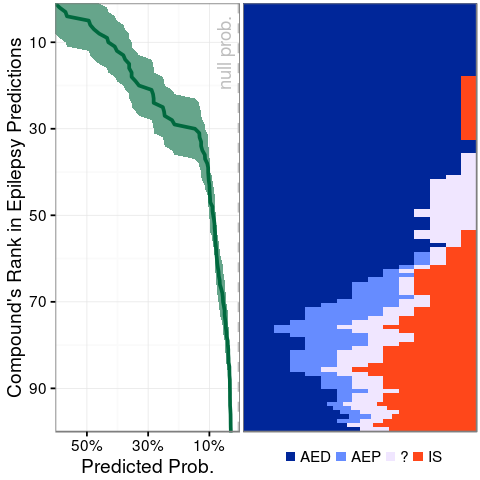

In [5]:
color_map = c(AED='#002699', AEP='#668cff', '?'='#f0e6ff', IS='#ff471a')
null_prob = 0.00361

gg_pred = window_df %>%
  ggplot2::ggplot(ggplot2::aes(x = disease_rank)) +
  ggplot2::geom_hline(yintercept = null_prob, size=0.7, linetype='dashed', color='grey') +
  ggplot2::annotate('text', x=4, y=null_prob, color='grey', label='null prob.', angle=90, vjust=-0.54, hjust=1) +
  ggplot2::geom_ribbon(ggplot2::aes(ymin = min_pred, ymax = max_pred), fill = '#66A58B') +
  ggplot2::geom_line(ggplot2::aes(y = prediction), size=1.05, lineend='round', color='#00693E') +
  ggplot2::coord_flip() +
  hetior::theme_dhimmel() +
  #ggplot2::scale_x_reverse(breaks=window_df$disease_rank, labels=tolower(window_df$name)) +
  ggplot2::scale_x_reverse(breaks=seq(10, 90, 20), expand=c(0,0), name="Compound's Rank in Epilepsy Predictions") +
  ggplot2::scale_y_reverse(expand=c(0,0), breaks=seq(.1, .5, .2), labels=scales::percent, name='Predicted Prob.') +
  ggplot2::expand_limits(y = 0) +
  ggplot2::theme(plot.margin = grid::unit(c(2, 0, 2, 2), 'points'))


gg_status = dplyr::bind_rows(
  area_df %>% dplyr::mutate(disease_rank = disease_rank - 0.499),
  area_df %>% dplyr::mutate(disease_rank = disease_rank + 0.499)) %>%
  dplyr::arrange(disease_rank) %>%
  ggplot2::ggplot(ggplot2::aes(x = disease_rank, y = window_freq, fill=window_status)) +
  ggplot2::geom_area() +
  ggplot2::scale_fill_manual(values=color_map, name=NULL) +
  hetior::theme_dhimmel() +
  ggplot2::coord_flip() +
  ggplot2::scale_x_reverse(name=NULL, labels=NULL, expand=c(0,0)) +
  ggplot2::scale_y_continuous(expand=c(0,0), name=NULL, labels=NULL) +
  ggplot2::theme(legend.position = 'bottom', axis.ticks=ggplot2::element_blank()
                 #, legend.background = ggplot2::element_rect(fill='gray90')
  ) +
  ggplot2::guides(fill = ggplot2::guide_legend(keywidth=.5, keyheight=.5)) +
  ggplot2::theme(plot.margin = grid::unit(c(2, 2, 2, -1), 'points'))

gg_epilepsy = cowplot::plot_grid(gg_pred, gg_status)


w = 4; h = 4

options(repr.plot.width=w, repr.plot.height=h)
gg_epilepsy

In [6]:
# Save to file
ggplot2::ggsave('figure/epilepsy.png', gg_epilepsy, width = w, height = h, dpi=300)
ggplot2::ggsave('figure/epilepsy.pdf', gg_epilepsy, width = w, height = h)